### Installation

In [ ]:
!pip install pettingzoo[atari] supersuit autorom pygame tqdm
!AutoROM --accept-license


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.0/552.0 kB 32.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.3/563.3 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 56.7 MB/s eta 0:00:00
  Created wheel for multi_agent_ale_py: filename=multi_agent_ale_py-0.1.11-cp311-cp311-linux_x86_64.whl size=721821 sha256=158c63f9d8c3e7a741e0c8b4720e3fca32cd7c826db5a72df516f9781d518833
  Stored in directory: /root/.cache/pip/wheels/1d/81/76/771ec8e34292c8a71dd6c4a52a1c0401f4d93cbfb54e02fce4
Successfully built multi_agent_ale_py
AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/AutoROM/roms
	/usr/local/lib/python3.11/dist-packages/multi_agent_ale_py/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/adventure.bin
Ins

In [ ]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from pettingzoo.atari import space_invaders_v2
import supersuit as ss
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class DQN(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super(DQN, self).__init__()
        c, h, w = obs_shape
        self.net = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        return self.net(x / 255.0)

class ReplayBuffer:
    def __init__(self, size=100000):
        self.buffer = deque(maxlen=size)

    def add(self, s, a, r, s_, d):
        self.buffer.append((s, a, r, s_, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_, d = map(np.array, zip(*batch))
        return s, a, r, s_, d

    def __len__(self):
        return len(self.buffer)


In [ ]:
class DQN(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super(DQN, self).__init__()
        c, h, w = obs_shape
        self.net = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        return self.net(x / 255.0)

class ReplayBuffer:
    def __init__(self, size=100000):
        self.buffer = deque(maxlen=size)

    def add(self, s, a, r, s_, d):
        self.buffer.append((s, a, r, s_, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_, d = map(np.array, zip(*batch))
        return s, a, r, s_, d

    def __len__(self):
        return len(self.buffer)


In [ ]:

# Shared training settings
NUM_EPISODES = 35
BATCH_SIZE = 32
BUFFER_SIZE = 50000
GAMMA = 0.99
LEARNING_RATE = 1e-4
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 50000
TARGET_UPDATE_FREQ = 1000
TRAIN_FREQ = 4

# Define the environment setup function
def make_env():
    env = space_invaders_v2.parallel_env()
    env = ss.color_reduction_v0(env, mode='B')
    env = ss.resize_v1(env, x_size=84, y_size=84)
    env = ss.frame_stack_v1(env, 4)
    env = ss.dtype_v0(env, np.uint8)
    return env

# Initialize env and agents
env = make_env()
agents = ["first_0", "second_0"]

# Convert obs shape to (C, H, W)
raw_obs_shape = env.observation_space("first_0").shape
obs_shape = (raw_obs_shape[-1], raw_obs_shape[0], raw_obs_shape[1])
n_actions = env.action_space("first_0").n

# Shared model, target model, optimizer and replay buffer
model = DQN(obs_shape, n_actions).to(device)
target_model = DQN(obs_shape, n_actions).to(device)
target_model.load_state_dict(model.state_dict())
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
replay_buffer = ReplayBuffer(BUFFER_SIZE)


In [ ]:
from collections import Counter
import torch
import numpy as np
import random

# Initialize PettingZoo parallel environment
env = space_invaders_v2.parallel_env()
env = ss.color_reduction_v0(env, mode='B')
env = ss.resize_v1(env, x_size=84, y_size=84)
env = ss.frame_stack_v1(env, 4)
env = ss.dtype_v0(env, np.uint8)

# Define agents
agents = ["first_0", "second_0"]

# Extract observation and action space info
obs_shape = (env.observation_space(agents[0]).shape[-1],
             env.observation_space(agents[0]).shape[0],
             env.observation_space(agents[0]).shape[1])
n_actions = env.action_space(agents[0]).n

# Initialize DQN and training components
model = DQN(obs_shape, n_actions).to(device)
target_model = DQN(obs_shape, n_actions).to(device)
target_model.load_state_dict(model.state_dict())
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
replay_buffer = ReplayBuffer(BUFFER_SIZE)

# Logging variables
reward_history_A = []
reward_history_B = []
cooperation_indices = []
losses = []
action_counts = {agent: Counter() for agent in agents}

steps_done = 0

# Training loop
for ep in range(NUM_EPISODES):
    obs, _ = env.reset(seed=ep)
    done = {agent: False for agent in agents}
    total_rewards = {agent: 0 for agent in agents}
    sabotages = 0

    while any(not done[agent] for agent in agents):
        actions = {}

        for agent in agents:
            if done[agent]:
                continue

            state = torch.tensor(obs[agent], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

            eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
            steps_done += 1

            if random.random() < eps_threshold:
                action = random.randint(0, n_actions - 1)
            else:
                with torch.no_grad():
                    q_values = model(state)
                    action = q_values.argmax().item()

            actions[agent] = action
            action_counts[agent][action] += 1

        next_obs, rewards, terminations, truncations, _ = env.step(actions)

        for agent in agents:
            if not done[agent]:
                replay_buffer.add(obs[agent], actions[agent], rewards[agent], next_obs[agent], terminations[agent])
                total_rewards[agent] += rewards[agent]

        obs = next_obs
        done = {agent: terminations[agent] or truncations[agent] for agent in agents}

        if len(replay_buffer) >= BATCH_SIZE:
            states, actions_b, rewards_b, next_states, dones = replay_buffer.sample(BATCH_SIZE)

            states = torch.tensor(states, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
            actions_b = torch.tensor(actions_b).unsqueeze(1).to(device)
            rewards_b = torch.tensor(rewards_b).to(device)
            next_states = torch.tensor(next_states, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
            dones = torch.tensor(dones, dtype=torch.float32).to(device)

            q_values = model(states).gather(1, actions_b).squeeze()
            next_q_values = target_model(next_states).max(1)[0].detach()
            expected_q_values = rewards_b + GAMMA * next_q_values * (1 - dones)

            loss = torch.nn.MSELoss()(q_values, expected_q_values)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Target network update
    if ep % 10 == 0:
        target_model.load_state_dict(model.state_dict())

    # Compute cooperation index
    score_A = total_rewards["first_0"]
    score_B = total_rewards["second_0"]
    reward_history_A.append(score_A)
    reward_history_B.append(score_B)

    score_gap = abs(score_A - score_B)
    total_score = score_A + score_B
    cooperation_score = total_score - score_gap
    cooperation_index = cooperation_score / (total_score + 1e-6)
    cooperation_indices.append(cooperation_index)

    # Optional sabotage tracking
    sabotages = min(sabotages, 3)

    print(f"Episode {ep+1:3d} | A: {score_A:.0f} | B: {score_B:.0f} | CoopIdx: {cooperation_index:.2f}")


Episode   1 | A: 415 | B: 405 | CoopIdx: 0.99
Episode   2 | A: 655 | B: 75 | CoopIdx: 0.21
Episode   3 | A: 560 | B: 470 | CoopIdx: 0.91
Episode   4 | A: 350 | B: 590 | CoopIdx: 0.74
Episode   5 | A: 430 | B: 250 | CoopIdx: 0.74
Episode   6 | A: 330 | B: 790 | CoopIdx: 0.59
Episode   7 | A: 340 | B: 485 | CoopIdx: 0.82
Episode   8 | A: 280 | B: 480 | CoopIdx: 0.74
Episode   9 | A: 245 | B: 475 | CoopIdx: 0.68
Episode  10 | A: 370 | B: 525 | CoopIdx: 0.83
Episode  11 | A: 330 | B: 610 | CoopIdx: 0.70
Episode  12 | A: 490 | B: 485 | CoopIdx: 0.99
Episode  13 | A: 315 | B: 535 | CoopIdx: 0.74
Episode  14 | A: 280 | B: 490 | CoopIdx: 0.73
Episode  15 | A: 330 | B: 585 | CoopIdx: 0.72
Episode  16 | A: 805 | B: 205 | CoopIdx: 0.41
Episode  17 | A: 245 | B: 850 | CoopIdx: 0.45
Episode  18 | A: 240 | B: 415 | CoopIdx: 0.73
Episode  19 | A: 620 | B: 25 | CoopIdx: 0.08
Episode  20 | A: 700 | B: 420 | CoopIdx: 0.75
Episode  21 | A: 470 | B: 275 | CoopIdx: 0.74
Episode  22 | A: 235 | B: 635 | Coop

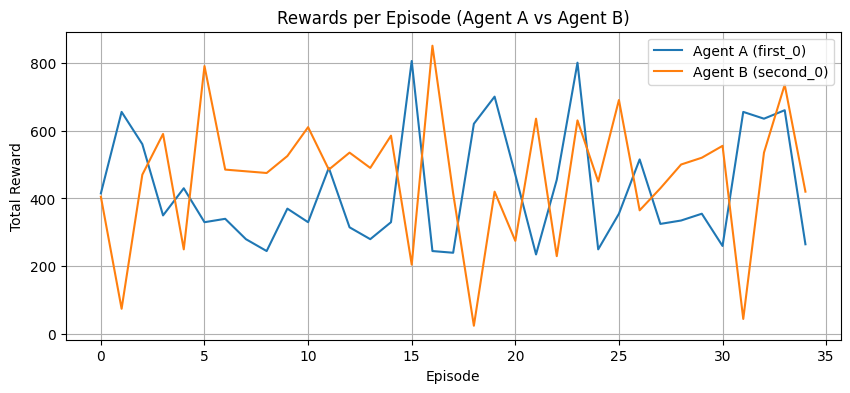

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
from IPython.display import HTML
from base64 import b64encode

# 1. Rewards per Episode
plt.figure(figsize=(10, 4))
plt.plot(reward_history_A, label="Agent A (first_0)")
plt.plot(reward_history_B, label="Agent B (second_0)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards per Episode (Agent A vs Agent B)")
plt.legend()
plt.grid(True)
plt.show()

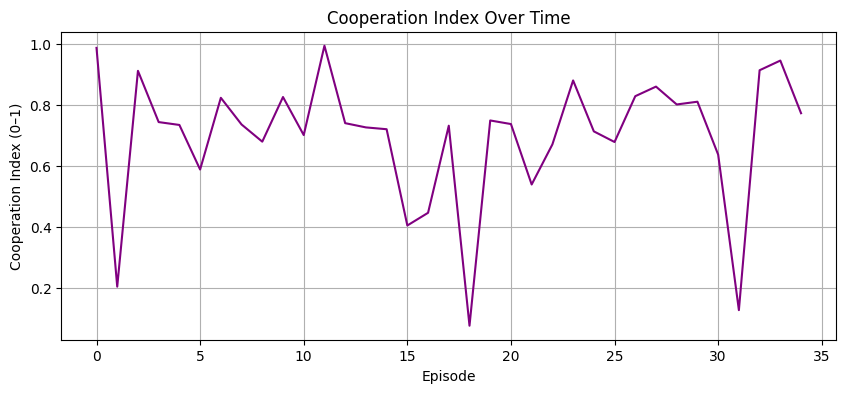

In [ ]:
# 2. Cooperation Index
plt.figure(figsize=(10, 4))
plt.plot(cooperation_indices, color="purple")
plt.xlabel("Episode")
plt.ylabel("Cooperation Index (0–1)")
plt.title("Cooperation Index Over Time")
plt.grid(True)
plt.show()

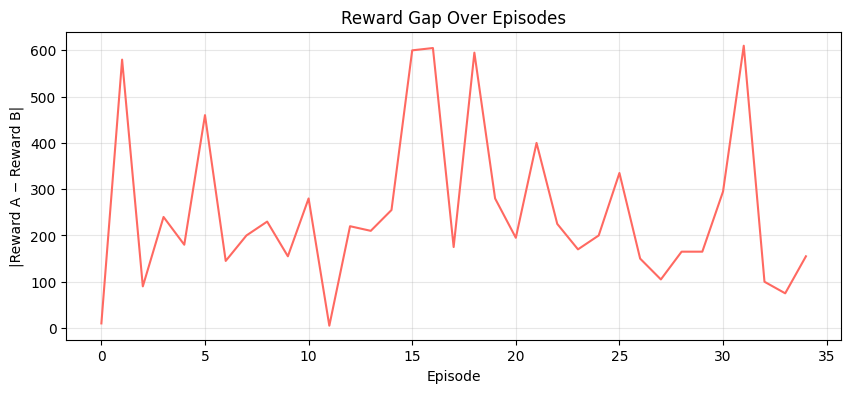

In [ ]:
# 3. Reward Gap
reward_gap = [abs(a - b) for a, b in zip(reward_history_A, reward_history_B)]
plt.figure(figsize=(10, 4))
plt.plot(reward_gap, color="#FF6961")
plt.xlabel("Episode")
plt.ylabel("|Reward A − Reward B|")
plt.title("Reward Gap Over Episodes")
plt.grid(True, alpha=0.3)
plt.show()

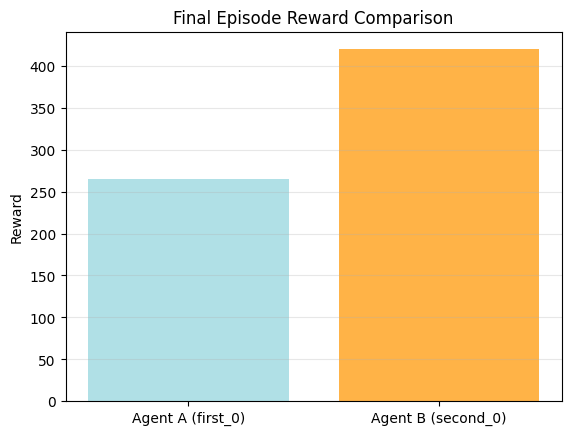

In [ ]:
# 4. Final Episode Reward Comparison
labels = ['Agent A (first_0)', 'Agent B (second_0)']
final_rewards = [reward_history_A[-1], reward_history_B[-1]]
plt.bar(labels, final_rewards, color=["#B0E0E6", "#FFB347"])
plt.title("Final Episode Reward Comparison")
plt.ylabel("Reward")
plt.grid(axis='y', alpha=0.3)
plt.show()

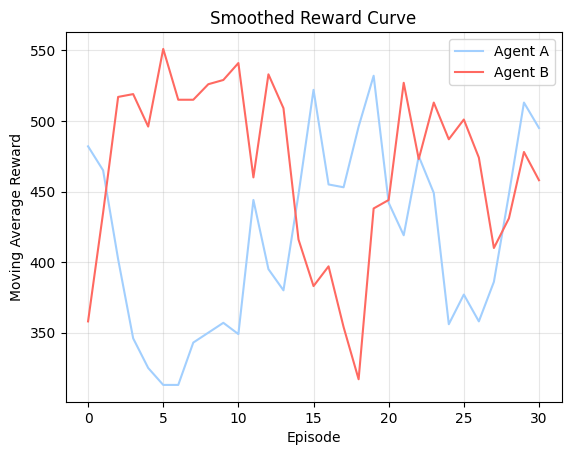

In [ ]:
# 5. Smoothed Reward Curve
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.plot(moving_average(reward_history_A), label="Agent A", color="#A2CFFE")
plt.plot(moving_average(reward_history_B), label="Agent B", color="#FF6961")
plt.title("Smoothed Reward Curve")
plt.xlabel("Episode")
plt.ylabel("Moving Average Reward")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

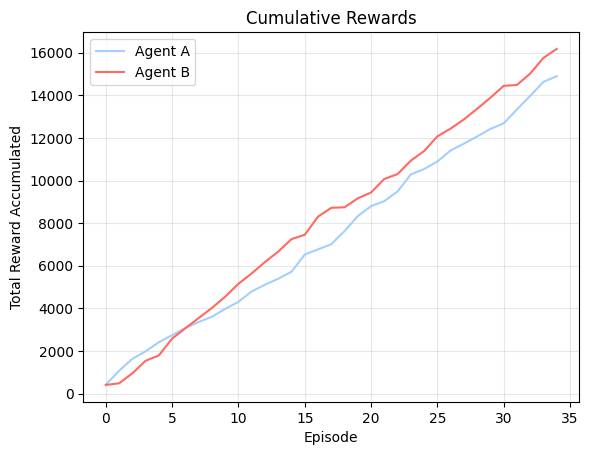

In [ ]:
# 6. Cumulative Rewards
cum_A = np.cumsum(reward_history_A)
cum_B = np.cumsum(reward_history_B)
plt.plot(cum_A, label="Agent A", color="#A2CFFE")
plt.plot(cum_B, label="Agent B", color="#FF6961")
plt.title("Cumulative Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward Accumulated")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

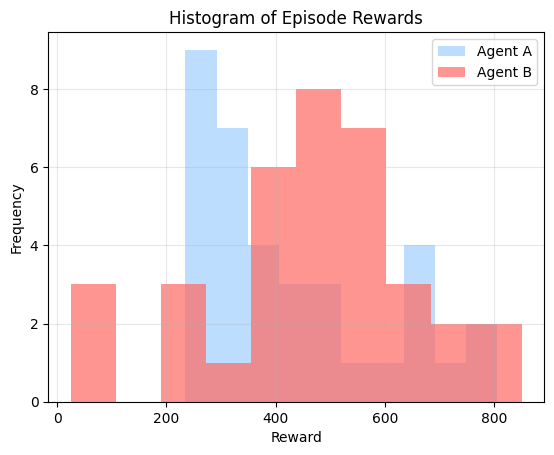

In [ ]:
# 7. Reward Histogram
plt.hist(reward_history_A, bins=10, alpha=0.7, label="Agent A", color="#A2CFFE")
plt.hist(reward_history_B, bins=10, alpha=0.7, label="Agent B", color="#FF6961")
plt.title("Histogram of Episode Rewards")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 8. Use raw AEC version of the environment
env = space_invaders_v2.env(render_mode="rgb_array")
env = ss.color_reduction_v0(env, mode='B')
env = ss.resize_v1(env, x_size=84, y_size=84)
env = ss.frame_stack_v1(env, 4)
env = ss.dtype_v0(env, np.uint8)
env.reset(seed=42)

frames = []

# Step through AEC loop
while env.agents:
    agent = env.agent_selection
    obs, reward, termination, truncation, _ = env.last()

    if termination or truncation:
        env.step(None)
        continue

    # Use shared trained DQN model
    state = torch.tensor(obs, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
    with torch.no_grad():
        q_values = model(state)
        action = q_values.argmax().item()

    env.step(action)

    # Capture RGB frame from env
    frame = env.render()
    frames.append(frame)

# Save video
video_path = "shared_dqn_gameplay.mp4"
imageio.mimsave(video_path, frames, fps=30)

# Display inline
mp4 = open(video_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display(HTML(f"""
<video width=512 controls>
    <source src="{data_url}" type="video/mp4">
</video>
"""))

# Download link
from google.colab import files
files.download(video_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>